This notebook demonstrates data interpolation using Gaussian smoothing

cf. Kevin Murhpy's MLaPP

Given a multivariate Gaussian $\textbf{x} \sim \mathcal{N}(x \hspace{2pt}|, \mu, \Sigma)$, 
suppose $\textbf{x} = (\textbf{x}_1, \textbf{x}_2)$ is jointly Gaussian:

$
\begin{equation}
\mu = \begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix} , \hspace{10pt}
\Sigma = \begin{bmatrix} \Sigma_{11} \hspace{3pt} \Sigma_{12} \\ \Sigma_{21} \hspace{3pt} \Sigma_{22} \end{bmatrix}, \hspace{10pt}
\Lambda = \Sigma^{-1} =  \begin{bmatrix} \Lambda_{11} \hspace{3pt} \Lambda_{12} \\ \Lambda_{21} \hspace{3pt} \Lambda_{22} \end{bmatrix}
\end{equation}
$

the marginal probabilities are: 

$
\begin{equation}
p(\textbf{x}_1) = \mathcal{N} (\textbf{x}_1 \hspace{2pt} |, \mu_1, \Sigma_1)\\
p(\textbf{x}_2) = \mathcal{N} (\textbf{x}_2 \hspace{2pt} |, \mu_2, \Sigma_2)
\end{equation}
$

the posterior conditional probabilities are:

$
\begin{equation}
p(\textbf{x}_1 \hspace{2pt} | \textbf{x}_2) = \mathcal{N} (\textbf{x}_1 \hspace{1pt} |  \hspace{1pt} \mu_{1|2}, \Sigma_{1|2})
\end{equation}
$

where 

$
\begin{align}
\mu_{ 1 \hspace{1pt} |  \hspace{1pt} 2 } &=& \mu_1 + \Sigma_{12} \Sigma_{22}^{-1} (\textbf{x}_2 - \mu_2) \\
&=& \mu_1 - \Lambda_{11}^{-1} \Lambda_{12} (\textbf{x}_2 - \mu_2)
\end{align}
$

and 

$
\begin{align}
\Sigma_{1 \hspace{1pt} | \hspace{1pt} 2} & = & \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-2} \Sigma_{21} \\
&=& \Lambda_{11}^{-1}
\end{align}
$

In [271]:
import random
import numpy as np
from numpy.linalg import inv

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [265]:
N = 23
n_points_to_interpolate = 16
D = N + n_points_to_interpolate

a0 = np.zeros(D)
a0[0] = -1; a0[1] = 2; a0[2] = -1

# Randomly generate the polynomial coefficients for the underlying function to be interpolated
coeffs = np.random.normal(size=4)
Left = -2
Right = 4

s = np.linspace(Left, Right, D)

s2_index = np.random.choice(range(0, D), replace=False, size=N)
s2_index.sort()
s1_index = np.array([i for i in range(0, D) if i not in s2_index])

x2 = np.polyval(coeffs, s[s2_index])
x1_exact = np.polyval(coeffs, s[s1_index])

exact_values = np.polyval(coeffs, s)

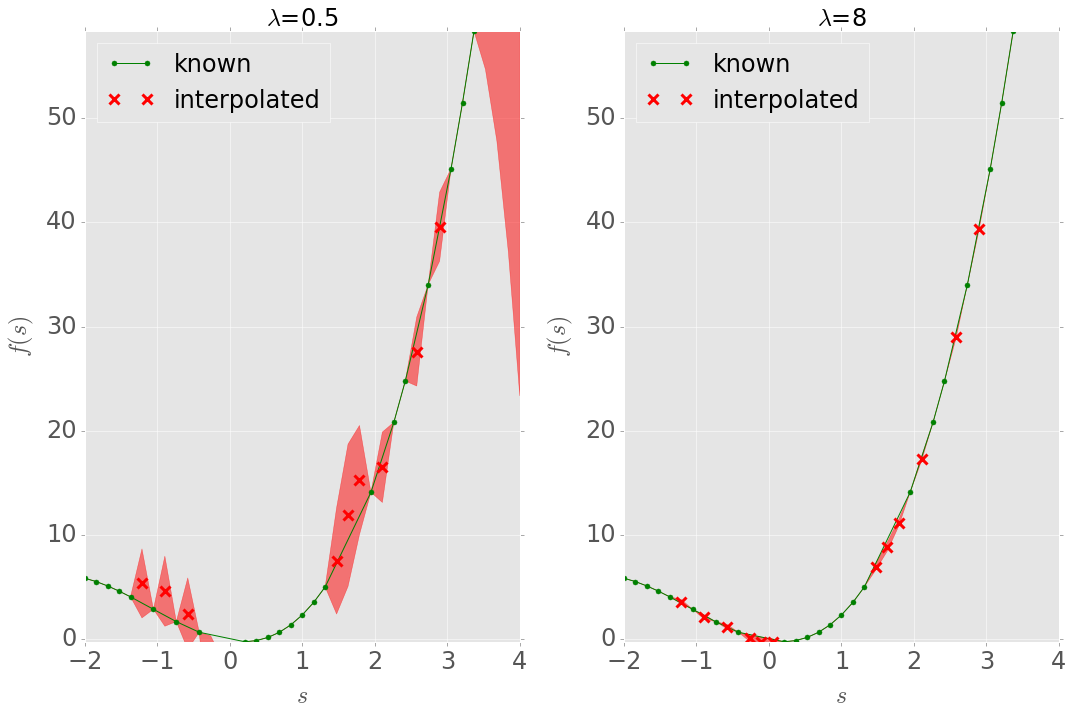

In [272]:
YMIN = np.min(x2)
YMAX = np.max(x2)

FONTSIZE = 24
plt.close('all')
fig = plt.figure(figsize=(15, 10))
gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1])

lambda_factors = [0.5, 8]
for i, lf in enumerate(lambda_factors):
    
    L = 0.5 * np.vstack([np.roll(a0, i) for i in range(D-2)])
    L *= lf
    
    L1 = L[:, s1_index]
    L2 = L[:, s2_index]
    
    lambda11 = L1.T.dot(L1)
    lambda12 = L1.T.dot(L2)

    mu_1on2 = - inv(lambda11).dot(lambda12).dot(x2)
    sigma_1on2 = inv(lambda11)

    random.seed(2215)
    x1_inter = np.random.multivariate_normal(mu_1on2, sigma_1on2) 
    x1_error = np.sqrt(np.diag(sigma_1on2))

    all_values = np.zeros_like(s)
    all_values[s1_index] = x1_inter
    all_values[s2_index] = x2
    errors = np.zeros_like(s)
    errors[s1_index] = x1_error
    errors[s2_index] = 0.0
    
    ax = plt.subplot(gs[0, i])
    known, = ax.plot(s[s2_index], x2, color='g', markersize=10, marker='.')
    fitted, = ax.plot(s[s1_index], x1_inter, color='r', marker='x', markersize=10, markeredgewidth=3, lw=0)
    ax.fill_between(s, all_values - 2 * errors, all_values + 2 * errors, color='r', alpha=0.5)
    ax.set_xlabel(r'$s$', fontsize=FONTSIZE, labelpad=10)
    ax.set_ylabel(r'$f(s)$', fontsize=FONTSIZE, labelpad=10)
    ax.set_xlim(Left, Right)
    ax.set_ylim(YMIN, YMAX)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FONTSIZE)
        tick.label.set_rotation(0)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(FONTSIZE)
        tick.label.set_rotation(0)       
    ax.set_title(r'$\lambda$={0:}'.format(lf), fontsize=FONTSIZE)
    legend = plt.legend((known, fitted), ('known', 'interpolated'), fontsize=FONTSIZE, loc='best')
plt.tight_layout(w_pad=2, h_pad=1)